In [274]:
import sys
sys.path.append('..')

import os
import shutil
from sqlalchemy import create_engine, text
import geopandas as gpd
import pandas as pd
from geopandas.tools import sjoin
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from shapely import wkb
import simplekml

from utilities_amigocloud import AmigocloudFunctions

In [2]:
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import API_AMIGOCLOUD_TOKEN_ADM
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

In [3]:
API_AMIGOCLOUD_TOKEN_ADM

'A:cf5xrxU3HgHj9FkLMiY5wW9LBFmvYDQG2TQ5FY'

In [251]:
# leer los dos shps de siembra y puntos de planificacion
PATH_SIEMBRA = RUTA_UNIDAD_ONE_DRIVE + r'Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\SHP\SIEMBRAS.shp'
PATH_CAT = RUTA_UNIDAD_ONE_DRIVE + r'Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\SHP\CATASTRO_S09_MIERCOLES.shp'
PATH_KML = RUTA_UNIDAD_ONE_DRIVE + r'Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\KML_PLAN'

gdf_siembras = gpd.read_file(PATH_SIEMBRA)
gdf_cat = gpd.read_file(PATH_CAT)

In [252]:
PATH_SIEMBRA

'G:\\Ingenio Azucarero Guabira S.A\\UTEA - SEMANAL - EQUIPO AVIACION UTEA\\Trichogramma\\2025\\SHP\\SIEMBRAS.shp'

In [277]:
def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

def obtener_planificacion_no_procesado():
    engine = obtener_engine()
    try:
        query = """
            SELECT id_os, geom, cod_ca, nom_ca, obs, procesado, producto, dosis
            FROM drones_control_bio.planificacion_ctrl_bio
            WHERE procesado=false;
        """
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return gpd.GeoDataFrame()
    return None

def obtener_parte_diario_por_id_os(id_os):
    engine = obtener_engine()
    try:
        query = f"""
            SELECT * FROM drones_control_bio.parte_diario_ctrl_bio where os = {id_os}
        """
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return gpd.GeoDataFrame()
    return None

def filtrar_os_y_quitar_caracteres(gdf, ors):
    # filtrar la semana de interes
    gdf_puntos_select = gdf[gdf['id_os'] == ors]
    gdf_puntos_sem = gdf_puntos_select.copy()
    #quita caracteres especiales
    gdf_puntos_sem['nom_ca'] = gdf_puntos_sem['nom_ca'].str.replace(r'[\r\n\t]', '', regex=True)
    return gdf_puntos_sem

def marcar_como_procesado(id_os):
    engine = obtener_engine()  # tu función que crea el engine
    try:
        with engine.begin() as conn:
            query = text("""
                UPDATE drones_control_bio.planificacion_ctrl_bio
                SET procesado = true
                WHERE id_os = :id_os
            """)
            conn.execute(query, {"id_os": id_os})
            print(f"✔️ id_os {id_os} marcado como procesado.")
    except Exception as e:
        print(f"❌ Error al actualizar: {e}")
    return None

def crear_puntos_individuales(gdf_fila):
    # Obtener la geometría del único registro
    geom = gdf_fila.iloc[0][gdf_fila.geometry.name]
    # Verificar si es MultiPoint
    if isinstance(geom, MultiPoint):
        # Crear un nuevo registro por cada punto
        registros = []
        for punto in geom.geoms:
            nuevo = gdf_fila.iloc[0].copy()
            nuevo[gdf_fila.geometry.name] = punto
            registros.append(nuevo)
        return gpd.GeoDataFrame(registros, geometry=gdf_fila.geometry.name, crs=gdf_fila.crs)
    else:
        # Si ya es un punto, retornar tal cual
        return gdf_fila.copy()

def definir_lotes_solicitud(gdf_puntos_indi):
    id_os = gdf_puntos_indi.iloc[0]['id_os']
    codigo_ca = gdf_puntos_indi.iloc[0]['cod_ca']
    nombre_ca = gdf_puntos_indi.iloc[0]['nom_ca']
    
    # Crear un GeoDataFrame vacío para almacenar los puntos que no intersectan con ningún polígono de siembra
    puntos_indi_solicitado = gdf_puntos_indi[~gdf_puntos_indi.geometry.apply(lambda point: any(gdf_siembras.contains(point)))]
    
    # identifoca los lotes que se intersectan
    gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi_solicitado, how='inner', predicate='intersects')    
    
    # filtra los lotes intersectados en la capa original
    poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
    
    # copy
    poligonos_intersect_cat = poligonos_intersect_cat.copy()
    poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]
    # Cambiar el nombre de la columna 'old_name' a 'new_name'
    poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)
    # CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
    poligonos_intersect_cat['unidad_03'] = codigo_ca
    poligonos_intersect_cat['unidad_04'] = nombre_ca
    
    # agrega los campos faltantes
    poligonos_intersect_cat['fecha_ini'] = ''
    poligonos_intersect_cat['origen'] = 'SOLICITUD'
    poligonos_intersect_cat['dias'] = 0
    poligonos_intersect_cat['fecha'] = ''
    poligonos_intersect_cat['os'] = id_os
    return poligonos_intersect_cat

def definir_lotes_siembra(gdf_puntos_indi):
    id_os = gdf_puntos_indi.iloc[0]['id_os']
    codigo_ca = gdf_puntos_indi.iloc[0]['cod_ca']
    nombre_ca = gdf_puntos_indi.iloc[0]['nom_ca']
    
    # SELECCIONAR LOS LOTES DE SIEMBRAS
    # identifoca los lotes que se intersectan
    gdf_lotes_siem = gpd.sjoin(gdf_siembras, gdf_puntos_indi, how='inner', predicate='intersects')
    # filtra los lotes intersectados en la capa original
    poligonos_intersect_siem = gdf_siembras.loc[gdf_siembras.index.isin(gdf_lotes_siem.index)]
    # copy
    poligonos_intersect_siem = poligonos_intersect_siem.copy()
    # agregar campo de semana_planificacion
    poligonos_intersect_siem['os'] = id_os
    # crea el campo soca, y coloca 0 o 1 dependiendo del origen
    poligonos_intersect_siem['soca'] = poligonos_intersect_siem['origen'].apply(lambda x: 1 if 'SIEMBRA 2024' in x else 0)
    # ordena los campos
    poligonos_intersect_siem = poligonos_intersect_siem[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'inst',
           'geometry', 'fecha_ini', 'origen', 'dias', 'fecha', 'os']]
    return poligonos_intersect_siem

def agregar_campos_faltantes(gdf_plan):
    gdf_plan['producto'] = ''
    gdf_plan['dosis'] = 0.0
    gdf_plan['id_labor'] = ''
    gdf_plan['fecha'] = ''
    gdf_plan['semana'] = 0
    gdf_plan['num_lib'] = 0
    gdf_plan['hora_ini'] = ''
    gdf_plan['hora_fin'] = ''
    gdf_plan['temp'] = 0
    gdf_plan['viento'] = 0
    gdf_plan['humedad'] = 0
    gdf_plan['cod_dron'] = ''
    gdf_plan['piloto_1'] = ''
    gdf_plan['piloto_2'] = ''
    gdf_plan['obs'] = ''
    gdf_plan['id_log'] = 0
    return gdf_plan

def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

def cargar_a_amigocloud(gdf):
    # repreyectar a WGS84
    gdf_pla_gral = gdf.to_crs(epsg=4326)
    # convertir poligonos a multipoligonos
    gdf_pla_gral['geom'] = gdf_pla_gral['geom'].apply(convertir_a_multipolygon)
    
    gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
    gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
    gdf_pla_gral['dias'] = gdf_pla_gral['dias'].astype(int)
    gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
    gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
    gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
    gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)
    
    # recorrer el gdf de lotes y cargarlo a amigocloud
    id_proyecto = 33457
    for index, row in gdf_pla_gral.iterrows():
        wkb_hex = convertir_a_wkb(row['geom'])
        insert_sql = f"""
            INSERT INTO dataset_345601 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, origen, dias, os, geometry)
            VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['origen']}', '{row['dias']}', '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
            """
        query_sql = {'query': insert_sql}
        resultado_post = amigocloud.ejecutar_query_sql(id_proyecto, insert_sql, 'post')
    return None

# verifica si en la dataframe existen nombres de lotes repetidos
def validar_lotes_repetidos(gdf_plan):
    cods_props = list(set(gdf_plan['unidad_01']))
    for i in cods_props:
        prop = gdf_plan[gdf_plan['unidad_01'] == i]
        if prop['unidad_05'].duplicated().any():
            return True
        else:
            return False
    return None

def crear_kmls(gdf_lotes):
    lista_cods = list(set(gdf_lotes['unidad_01']))
    for i in lista_cods:
        prop = gdf_lotes[gdf_lotes['unidad_01'] == i]
        prop_wgs = prop.to_crs(epsg=4326)
        output_folder = PATH_KML + '\\' + str(i)
        print(output_folder)
        
        if os.path.exists(output_folder):
            shutil.rmtree(output_folder)  # Elimina toda la carpeta y su contenido
        os.makedirs(output_folder)  # La vuelve a crear vacía
        
        # Recorrer el GeoDataFrame
        for idx, row in prop_wgs.iterrows():
            # Crear un nuevo documento KML
            kml_doc = simplekml.Kml()
            # Obtener el polígono y el nombre
            polygon = row['geom']
            name = row['unidad_05']
            # Convertir el polígono en una lista de coordenadas
            if polygon.geom_type == "Polygon":
                coords = [(x, y) for x, y in zip(*polygon.exterior.xy)]
            elif polygon.geom_type == "MultiPolygon":
            # puedes iterar si quieres más de uno, aquí tomamos el primero
                first_poly = list(polygon.geoms)[0]
                coords = [(x, y) for x, y in zip(*first_poly.exterior.xy)]
            else:
                print(f"❌ Geometría no compatible: {polygon.geom_type}")
                continue  # salta este registro
            # Añadir el polígono al documento KML
            pol = kml_doc.newpolygon(name=name, outerboundaryis=coords)
            # Guardar el archivo KML
            file_name = f"{name}.kml"
            output_path = os.path.join(output_folder, file_name)
            kml_doc.save(output_path)
    return None

In [8]:
amigocloud = AmigocloudFunctions(token=API_AMIGOCLOUD_TOKEN_ADM)
amigocloud

# ACTUALIZAR SHP PLANIFICACION

In [253]:
gdf_puntos = obtener_planificacion_no_procesado()

In [254]:
gdf_puntos

,id_os,geom,cod_ca,nom_ca,obs,procesado,producto,dosis
0,29,"MULTIPOINT (437635.091 8096115.083, 437363.252...",566,ARNEZ DURAN PEDRO,None,False,trichogramma,6.0


In [255]:
puntos_individuales = crear_puntos_individuales(gdf_puntos.iloc[[0]])
puntos_individuales

,id_os,geom,cod_ca,nom_ca,obs,procesado,producto,dosis
0,29,POINT (437635.091 8096115.083),566,ARNEZ DURAN PEDRO,None,False,trichogramma,6.0
0,29,POINT (437363.252 8096352.512),566,ARNEZ DURAN PEDRO,None,False,trichogramma,6.0
0,29,POINT (437714.234 8096359.394),566,ARNEZ DURAN PEDRO,None,False,trichogramma,6.0
0,29,POINT (437961.987 8096252.723),566,ARNEZ DURAN PEDRO,None,False,trichogramma,6.0
0,29,POINT (438109.950 8096538.326),566,ARNEZ DURAN PEDRO,None,False,trichogramma,6.0


In [256]:
lotes_solicidud = definir_lotes_solicitud(puntos_individuales)

In [257]:
lotes_siembra = definir_lotes_siembra(puntos_individuales)

In [258]:
dfs = [df for df in [lotes_solicidud, lotes_siembra] if not df.empty]

In [259]:
concat_plan = pd.concat(dfs, axis=0, ignore_index=True)

In [260]:
concat_plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,fecha_ini,origen,dias,fecha,os
0,172.0,EL TESORO--ARNEZ Y COLQUE,566,ARNEZ DURAN PEDRO,L2,6.048380,11.0,304,"POLYGON ((437344.214 8096437.390, 437375.122 8...",,SOLICITUD,0.0,,29
1,172.0,EL TESORO--ARNEZ Y COLQUE,566,ARNEZ DURAN PEDRO,L1.2,4.828282,3.0,304,"POLYGON ((437910.413 8096340.896, 437745.240 8...",,SOLICITUD,0.0,,29
2,172.0,EL TESORO--ARNEZ Y COLQUE,566,ARNEZ DURAN PEDRO,L6.1,7.194420,1.0,304,"POLYGON ((437605.631 8095962.511, 437557.206 8...",,SOLICITUD,0.0,,29
3,172,EL TESORO--ARNEZ Y COLQUE,41533,ARNEZ COLQUE ROSARIO ESTELA,L1,8.000077,0.0,304.0,"POLYGON ((437968.377 8096372.844, 437967.841 8...",None,SIEMBRA 2025,0.0,None,29
4,172,EL TESORO--ARNEZ Y COLQUE,41533,ARNEZ COLQUE ROSARIO ESTELA,L7,12.378660,0.0,304.0,"POLYGON ((437828.110 8096301.969, 437917.637 8...",None,SIEMBRA 2025,0.0,None,29


In [261]:
plan = agregar_campos_faltantes(concat_plan)

In [262]:
plan.columns

Index(['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area',
       'soca', 'inst', 'geometry', 'fecha_ini', 'origen', 'dias', 'fecha',
       'os', 'producto', 'dosis', 'id_labor', 'semana', 'num_lib', 'hora_ini',
       'hora_fin', 'temp', 'viento', 'humedad', 'cod_dron', 'piloto_1',
       'piloto_2', 'obs', 'id_log'],
      dtype='object')

In [264]:
validar_lotes_repetidos(plan)

False

In [279]:
for i, row in gdf_puntos.iterrows():
    ors = row['id_os']
    produc_plan = row['producto']
    produc_dosis = row['dosis']
    
    puntos = filtrar_os_y_quitar_caracteres(gdf_puntos, ors)
    multipoint_gdf = puntos.copy()
    puntos_individuales = crear_puntos_individuales(multipoint_gdf)
    
    lotes_solicidud = definir_lotes_solicitud(puntos_individuales)
    lotes_siembra = definir_lotes_siembra(puntos_individuales)

    # verificar si algun dataframe esta vacio
    dfs = [df for df in [lotes_solicidud, lotes_siembra] if not df.empty]
    # concatena los dfs no vacios
    concat_plan = pd.concat(dfs, axis=0, ignore_index=True)
    
    plan = agregar_campos_faltantes(concat_plan)
    #RECALCULAR EL AREA
    plan['area'] = plan.geometry.area / 10000

    plan['producto_plan'] = produc_plan
    plan['producto_dosis'] = produc_dosis
    plan['producto_cantidad'] = plan['area'] * plan['producto_dosis']
    
    plan.rename(columns={'geometry': 'geom'}, inplace=True)
    plan = plan.set_geometry("geom")
    plan['unidad_01'] = plan['unidad_01'].astype(int)
    plan['unidad_03'] = plan['unidad_03'].astype(int)
    plan['dias'] = plan['dias'].astype(int)
    plan['os'] = plan['os'].astype(int)
    plan['soca'] = plan['soca'].astype(int)
    plan['inst'] = plan['inst'].astype(int)

    # validas que la planificacion no tenga lotes con el mismo nombre
    if validar_lotes_repetidos(plan):
        print(f"ERROR: Existen lotes con nombre repetido en la propiedad: {plan.iloc[0]['unidad_01']}")
        continue
    crear_kmls(plan)    
    plan.to_postgis("parte_diario_ctrl_bio", obtener_engine(), schema="drones_control_bio", if_exists="append")
    
    # CARGAR LOTES A AMIGOCLOUD
    #cargar_a_amigocloud(plan_os)
    
    marcar_como_procesado(ors)

G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\KML_PLAN\172
✔️ id_os 29 marcado como procesado.


<Axes: >

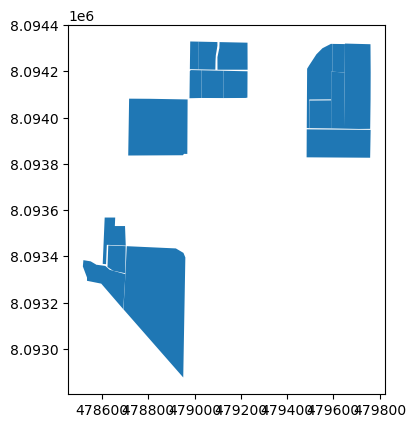

In [30]:
plan_os.plot()